In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import joblib

2024-10-22 21:29:53.358281: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 21:29:53.506814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 21:29:53.563536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 21:29:53.581323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 21:29:53.692045: I tensorflow/core/platform/cpu_feature_guar

# Loading the files

In [2]:
# Loading datasets 1 and 3
df_1 = pd.read_csv('./datasets/train/train_emoticon.csv')
df_3 = pd.read_csv('./datasets/train/train_text_seq.csv')
valid_df_1 = pd.read_csv('./datasets/valid/valid_emoticon.csv')
valid_df_3 = pd.read_csv('./datasets/valid/valid_text_seq.csv')

In [3]:
# Loading and preprocessing dataset 2
path = './datasets/train/train_feature.npz'
path_valid = './datasets/valid/valid_feature.npz'
with np.load(path) as data:
  train_examples = data['features']
  train_labels = data['label']
with np.load(path_valid) as data:
  valid_examples = data['features']
  valid_labels = data['label']

print(train_examples.shape, train_labels.shape)

train_examples = np.asarray(train_examples, dtype=np.float32)
train_labels = np.asarray(train_labels, dtype=np.int32)
valid_examples = np.asarray(valid_examples, dtype=np.float32)
valid_labels = np.asarray(valid_labels, dtype=np.int32)

train_examples_flat = train_examples.reshape(train_examples.shape[0], -1)
train_data_with_labels = np.hstack((train_examples_flat, train_labels.reshape(-1, 1)))
df_2 = pd.DataFrame(train_data_with_labels) 
valid_examples_flat = valid_examples.reshape(valid_examples.shape[0], -1)
valid_data_with_labels = np.hstack((valid_examples_flat, valid_labels.reshape(-1, 1)))
valid_df_2 = pd.DataFrame(valid_data_with_labels)

(7080, 13, 768) (7080,)


In [4]:
df_1_no_label = df_1.drop(columns=['label'])
df_2_no_label = df_2.drop(columns=[9984])

# Merged Training data
merged_df = pd.concat([df_1_no_label, df_2_no_label, df_3], axis=1)

valid_df_1_no_label = valid_df_1.drop(columns=['label'])
valid_df_2_no_label = valid_df_2.drop(columns=[9984])

# Merged Validation data
valid_merged_df = pd.concat([valid_df_1_no_label, valid_df_2_no_label, valid_df_3], axis=1)


In [5]:
train_texts = merged_df['input_emoticon'].values
train_labels = merged_df['label'].values
validation_texts = valid_df_1['input_emoticon'].values
validation_labels = valid_df_1['label'].values

tokenizer = Tokenizer(char_level=True)  
tokenizer.fit_on_texts(train_texts) 
train_sequences = tokenizer.texts_to_sequences(train_texts)
valid_sequences = tokenizer.texts_to_sequences(validation_texts)

max_len = max([len(seq) for seq in train_sequences])   
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
train_labels = train_labels.astype(int)

validation_padded = pad_sequences(valid_sequences, maxlen=max_len, padding='post')
validation_labels = validation_labels.astype(int)


In [6]:
merged_df.drop(columns=['input_emoticon'], inplace=True)
valid_merged_df.drop(columns=['input_emoticon'], inplace=True)
train_padded_df = pd.DataFrame(train_padded, columns=[f'padded_{i}' for i in range(train_padded.shape[1])])
merged_df = pd.concat([train_padded_df,merged_df], axis=1)
merged_df

,padded_0,padded_1,padded_2,padded_3,padded_4,padded_5,padded_6,padded_7,padded_8,padded_9,...,9976,9977,9978,9979,9980,9981,9982,9983,input_str,label
0,4,5,32,1,2,127,3,6,18,7,...,-0.118184,-0.131268,-0.248308,-0.030563,-0.210591,-0.028888,0.016804,0.082894,0000154364642718159661428002624223132284159626...,0
1,5,1,33,4,6,3,2,111,1,3,...,-0.103064,-0.059938,-0.253473,-0.177246,-0.040373,0.140488,-0.020949,-0.003448,0004641596369515436422262614110471596262476161...,0
2,4,3,1,46,2,6,5,103,2,3,...,-0.047782,-0.149243,-0.252450,-0.023745,0.010205,0.043697,-0.008699,0.000463,0001543626215965999614422464135806142624051159...,0
3,4,6,5,92,2,3,1,199,1,7,...,-0.117015,-0.145422,-0.231792,-0.048320,-0.089497,-0.059478,0.082911,-0.024833,0000154364224641238614262159689561596284351061...,1
4,5,93,6,4,210,1,2,3,67,3,...,-0.103064,-0.059938,-0.253473,-0.177246,-0.040373,0.140488,-0.020949,-0.003448,0004641899422154362069015966142624761262159661...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7075,3,120,32,1,2,5,4,6,7,3,...,-0.147763,-0.128285,-0.265402,-0.155221,-0.201739,-0.136390,-0.054164,0.018522,0000026267027181596614464154364222842626141596...,1
7076,5,6,81,3,2,195,4,1,1,7,...,-0.076066,-0.054807,-0.244673,-0.058179,-0.095887,-0.010896,0.001057,-0.034770,0000464422155826261433491543615961596284614390...,1
7077,172,1,37,4,2,3,5,6,7,26,...,-0.011560,0.037240,-0.251265,0.009879,-0.069403,0.065474,0.131174,-0.091966,0003069915964309154366142624644222841795262614...,1
7078,2,1,4,83,5,3,6,190,3,1,...,0.142050,-0.180895,-0.214470,0.153109,-0.050370,0.052357,-0.034153,-0.083809,0000614159615436198346426242237758262159694061...,0


In [7]:
valid_padded_df = pd.DataFrame(validation_padded, columns=[f'padded_{i}' for i in range(validation_padded.shape[1])])
valid_merged_df = pd.concat([valid_padded_df,valid_merged_df], axis=1)
valid_merged_df

,padded_0,padded_1,padded_2,padded_3,padded_4,padded_5,padded_6,padded_7,padded_8,padded_9,...,9976,9977,9978,9979,9980,9981,9982,9983,input_str,label
0,6,4,44,1,2,194,3,5,7,1,...,-0.076066,-0.054807,-0.244673,-0.058179,-0.095887,-0.010896,0.001057,-0.034770,0004221543626231596614341412624642841596614262...,1
1,5,2,214,4,50,3,1,6,1,3,...,-0.021044,-0.028154,-0.275227,-0.145210,-0.049569,-0.093691,0.162462,-0.108675,0004646141250615436232726215964221596262614284...,1
2,6,5,182,4,3,94,2,1,82,3,...,0.084240,-0.073388,-0.237486,0.109919,0.043377,0.081005,-0.041821,0.119433,0004224644543615436262336561415962713262159628...,0
3,4,17,1,117,2,3,6,5,2,18,...,-0.118184,-0.131268,-0.248308,-0.030563,-0.210591,-0.028888,0.016804,0.082894,0000154361120159643716142624224646143132262284...,0
4,19,1,164,4,2,5,6,3,86,2,...,-0.057454,0.068505,-0.268164,-0.128146,-0.190372,-0.097099,0.234058,-0.173977,0003324159623684154366144644222625705614284159...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,3,71,5,6,1,2,4,194,1,7,...,-0.125898,-0.009716,-0.248754,-0.274071,-0.099834,-0.156583,0.088166,0.043699,0002621157464422159661415436341411596284614262...,1
485,2,3,93,5,6,4,144,1,90,3,...,-0.044685,-0.074306,-0.243231,0.043470,0.097231,0.115097,-0.027389,0.124625,0000614262189946442215436262015962998262159628...,0
486,2,99,3,5,6,1,4,68,2,7,...,-0.066240,-0.209952,-0.239671,0.045708,-0.051223,0.060893,-0.034021,-0.059369,0000614622426246442215961543627806142841983159...,0
487,5,2,128,3,1,55,4,6,2,7,...,-0.112629,-0.103027,-0.236560,-0.114273,-0.244401,-0.030974,0.058870,-0.021004,0000464614150226215964349154364226142841596262...,0


In [8]:
def split_into_chunks(input_str, chunk_size=2):
    return [input_str[i:i+chunk_size] for i in range(0, len(input_str), chunk_size)]

chunks_df_valid = merged_df['input_str'].apply(split_into_chunks).apply(pd.Series)
chunks_df_valid.columns = [f'chunk_{i+1}' for i in range(chunks_df_valid.shape[1])]
merged_df = pd.concat([merged_df, chunks_df_valid], axis=1)

merged_df.drop(columns=['input_str'], inplace=True)

chunks_df_valid = valid_merged_df['input_str'].apply(split_into_chunks).apply(pd.Series)
chunks_df_valid.columns = [f'chunk_{i+1}' for i in range(chunks_df_valid.shape[1])]
valid_merged_df = pd.concat([valid_merged_df, chunks_df_valid], axis=1)

valid_merged_df.drop(columns=['input_str'], inplace=True)

In [9]:
merged_df

,padded_0,padded_1,padded_2,padded_3,padded_4,padded_5,padded_6,padded_7,padded_8,padded_9,...,chunk_16,chunk_17,chunk_18,chunk_19,chunk_20,chunk_21,chunk_22,chunk_23,chunk_24,chunk_25
0,4,5,32,1,2,127,3,6,18,7,...,42,23,13,22,84,15,96,26,26,14
1,5,1,33,4,6,3,2,111,1,3,...,04,71,59,62,62,47,61,61,42,84
2,4,3,1,46,2,6,5,103,2,3,...,58,06,14,26,24,05,11,59,62,84
3,4,6,5,92,2,3,1,199,1,7,...,95,61,59,62,84,35,10,61,42,62
4,5,93,6,4,210,1,2,3,67,3,...,26,24,76,12,62,15,96,61,42,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7075,3,120,32,1,2,5,4,6,7,3,...,42,22,84,26,26,14,15,96,24,14
7076,5,6,81,3,2,195,4,1,1,7,...,59,61,59,62,84,61,43,90,12,62
7077,172,1,37,4,2,3,5,6,7,26,...,42,22,84,17,95,26,26,14,15,96
7078,2,1,4,83,5,3,6,190,3,1,...,77,58,26,21,59,69,40,61,42,84


In [10]:
# Calculate feature correlations with the target
correlations = merged_df.drop(columns=['label']).corrwith(merged_df['label'])

# Set the correlation threshold
correlation_threshold = 0.00001

# Select features with correlation above the threshold
selected_features = correlations[abs(correlations) > correlation_threshold].index.tolist()

# Filter the training and validation data to include only selected features
merged_df_filtered = merged_df[selected_features + ['label']]
valid_merged_df_filtered = valid_merged_df[selected_features + ['label']]

print(f"Original number of features: {merged_df.shape[1] - 1}")  # Subtract 1 to exclude the 'label' column
print(f"Number of features after correlation filtering: {len(selected_features)}")

# Update the merged datasets
merged_df1 = merged_df_filtered
valid_merged_df1 = valid_merged_df_filtered


/tmp/ipykernel_43512/659514607.py:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = merged_df.drop(columns=['label']).corrwith(merged_df['label'])
/home/hardikj/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/hardikj/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Original number of features: 10022
Number of features after correlation filtering: 2317


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train = merged_df.drop(columns=['label'])
valid = valid_merged_df.drop(columns=['label'])
train_labels = merged_df['label']
valid_labels = valid_merged_df['label']

# Convert column names to strings
train.columns = train.columns.astype(str)
valid.columns = valid.columns.astype(str)

clf = RandomForestClassifier(n_estimators=250, random_state=0)
clf.fit(train, train_labels)
y_pred = clf.predict(valid)
print("Accuracy:", accuracy_score(valid_labels, y_pred))

Accuracy: 0.983640081799591


In [12]:
joblib.dump(clf, './models/combined.joblib')

['./models/combined.joblib']

In [13]:
from sklearn.model_selection import train_test_split

train_examples_80, train_examples_20, train_labels_80, train_labels_20 = train_test_split( train, train_labels, test_size=0.2, random_state=42)
train_examples_70, train_examples_30, train_labels_70, train_labels_30 = train_test_split( train, train_labels, test_size=0.3, random_state=42)
train_examples_60, train_examples_40, train_labels_60, train_labels_40 = train_test_split( train, train_labels, test_size=0.4, random_state=42)
train_examples_50, train_examples_50, train_labels_50, train_labels_50 = train_test_split( train, train_labels, test_size=0.5, random_state=42)

In [21]:
clf = RandomForestClassifier(n_estimators=250, random_state=0)
clf.fit(train, train_labels)
y_pred = clf.predict(valid)
acc_100 = accuracy_score(valid_labels, y_pred)
print("Accuracy with 100%:", acc_100)

Accuracy with 100%: 0.983640081799591


In [22]:

clf_1 = RandomForestClassifier(n_estimators=250, random_state=0)
clf_1.fit(train_examples_80, train_labels_80)
y_pred = clf_1.predict(valid)
acc_80 = accuracy_score(valid_labels, y_pred)
print("Accuracy with 80%:", acc_80)

Accuracy with 80%: 0.9877300613496932


In [23]:
clf_2 = RandomForestClassifier(n_estimators=250, random_state=0)
clf_2.fit(train_examples_60, train_labels_60)
y_pred = clf_2.predict(valid)
acc_60 = accuracy_score(valid_labels, y_pred)
print("Accuracy with 60%:", acc_60)

Accuracy with 60%: 0.9795501022494888


In [24]:
clf_3 = RandomForestClassifier(n_estimators=250,  random_state=0)
clf_3.fit(train_examples_40, train_labels_40)
y_pred = clf_3.predict(valid)
acc_40 = accuracy_score(valid_labels, y_pred)
print("Accuracy with 40%:", acc_40)

Accuracy with 40%: 0.9652351738241309


In [25]:
clf_4 = RandomForestClassifier(n_estimators=250, random_state=0)
clf_4.fit(train_examples_20, train_labels_20)
y_pred = clf_4.predict(valid)
acc_20 = accuracy_score(valid_labels, y_pred)
print("Accuracy with 20%:", acc_20)

Accuracy with 20%: 0.9488752556237219


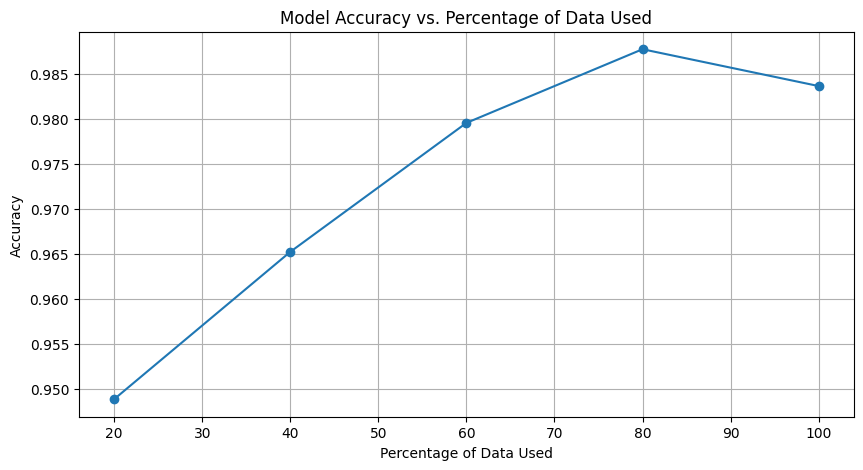

In [26]:
import matplotlib.pyplot as plt

# Percentages of data used
percentages = [100, 80, 60, 40, 20]

# Accuracies corresponding to the percentages 
accuracies = [acc_100, acc_80, acc_60, acc_40, acc_20]

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(percentages, accuracies, marker='o')
plt.title('Model Accuracy vs. Percentage of Data Used')
plt.xlabel('Percentage of Data Used')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()